NOTE: only works for agg='arr' and agg='prov'.

Remarks:
- The 'market share' is scaled to the entire population. This includes babies and elderly people, which is technically not part of the 'market' Proximus is aiming toward. Still, this serves as a good proxy for the relevant population.
- This has been summarised in the function `scale_staytime_to_market_share`

In [2]:
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.utils import moving_avg

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [144]:
# Load population in aggregated geographical unit
# Load Proximus clients per municipality (under NIS code)

raw_dir = '../../data/raw/mobility/proximus/postalcodes/'
d = '20201221'
agg='arr'

pc_to_nis = load_pc_to_nis()
pop_per_nis = pd.read_csv(f'../../data/interim/demographic/initN_{agg}.csv', dtype={'NIS' : str})[['NIS','total']].set_index('NIS').rename_axis('mllp_postalcode', axis='index')

raw_data = load_datafile_proximus(d, raw_dir)
value_per_pc = raw_data[['mllp_postalcode','imsisinpostalcode']].drop_duplicates().set_index('mllp_postalcode')

rename_idx_dict = dict({})
rename_foreigner = 'Foreigner'
for pc in value_per_pc.index:
    if pc != 'Foreigner':
        NIS = str(pc_to_nis[pc_to_nis['Postcode']==int(pc)]['NISCode'].values[0])
        rename_idx_dict[pc] = NIS
rename_idx_dict['Foreigner'] = rename_foreigner

value_per_pc = value_per_pc.rename(index=rename_idx_dict).groupby(level=0, axis=0).sum()
value_per_pc

pop_per_nis.head()

,total
mllp_postalcode,
11000,1057736
12000,347125
13000,464869
21000,1218255
23000,643766


In [145]:
# Aggregate NIS codes to arrondissements or provinces
# NOTE only execute this cell ONCE

# Rename rows
for nis in value_per_pc.index:
    if nis != 'Foreigner':
        new_nis = nis[:-3] + '000'
        value_per_pc = value_per_pc.rename(index={nis : new_nis})

# Collect rows and columns with the same NIS code, and automatically order column/row names
value_per_pc = value_per_pc.groupby(level=0, axis=0).sum()

if agg == 'prov':
    # Rename rows
    for nis in value_per_pc.index:
        if nis not in ['Foreigner', '21000', '23000', '24000', '25000']:
            new_nis = nis[:-4] + '0000'
            value_per_pc = value_per_pc.rename(index={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            value_per_pc = value_per_pc.rename(index={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            value_per_pc = value_per_pc.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    value_per_pc = value_per_pc.groupby(level=0, axis=0).sum()
    
value_per_pc = value_per_pc.join(pop_per_nis)
value_per_pc.head()

,imsisinpostalcode,total
mllp_postalcode,,
11000,281144.0,1057736.0
12000,113578.0,347125.0
13000,136227.0,464869.0
21000,352385.0,1218255.0
23000,246168.0,643766.0
24000,169729.0,512077.0
25000,191721.0,406019.0
31000,91626.0,282745.0
32000,14396.0,51696.0


In [131]:
value_per_pc['fraction'] = value_per_pc['imsisinpostalcode']/value_per_pc['total']
value_per_pc.loc['Foreigner', 'fraction']=1.0
value_per_pc.head()

,imsisinpostalcode,total,fraction
mllp_postalcode,,,
11000,281144.0,1057736.0,0.265798
12000,113578.0,347125.0,0.327196
13000,136227.0,464869.0,0.293044
21000,352385.0,1218255.0,0.289254
23000,246168.0,643766.0,0.382387
24000,169729.0,512077.0,0.331452
25000,191721.0,406019.0,0.472197
31000,91626.0,282745.0,0.324059
32000,14396.0,51696.0,0.278474


In [134]:
for nis in value_per_pc.index:
    value_per_pc.loc[nis] /= value_per_pc.loc[nis,'fraction']
value_per_pc.head()

,imsisinpostalcode,total,fraction
mllp_postalcode,,,
11000,1057736.0,3.979475e+06,1.0
12000,347125.0,1.060908e+06,1.0
13000,464869.0,1.586346e+06,1.0
21000,1218255.0,4.211715e+06,1.0
23000,643766.0,1.683544e+06,1.0
24000,512077.0,1.544950e+06,1.0
25000,406019.0,8.598507e+05,1.0
31000,282745.0,8.725115e+05,1.0
32000,51696.0,1.856402e+05,1.0


**PLOTTING THIS IN GEOPANDAS**

In [108]:
# Visualisation in geopandas
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

shp_dir = "../../data/raw/GIS/shapefiles/BE/"

# Load different geographical aggregations
# country = gp.read_file(shp_dir + "AD_6_Country.shp")
# regions = gp.read_file(shp_dir + "AD_5_Region.shp")
# provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")
# municipalities = gp.read_file(shp_dir + "AD_2_Municipality.shp")

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Create circle denoting foreigners
# import shapely.affinity
# from shapely.geometry import Point
# circle = Point(570000, 600000).buffer(1)  # type(circle)=polygon
# radius = 1.3e4
# ellipse = shapely.affinity.scale(circle, radius, radius)  # type(ellipse)=polygon

# Add additional column to geopandas dataframes for foreigners, depicted by circle
# foreign_mun = pd.DataFrame([[np.nan, np.nan, np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=municipalities.columns)
# municipalities = municipalities.append(foreign_mun, ignore_index=True)

# foreign_arr = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=arrondissements.columns)
# arrondissements = arrondissements.append(foreign_arr, ignore_index=True)

# foreign_prov = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=provinces.columns)
# provinces = provinces.append(foreign_prov, ignore_index=True)

<IPython.core.display.Javascript object>


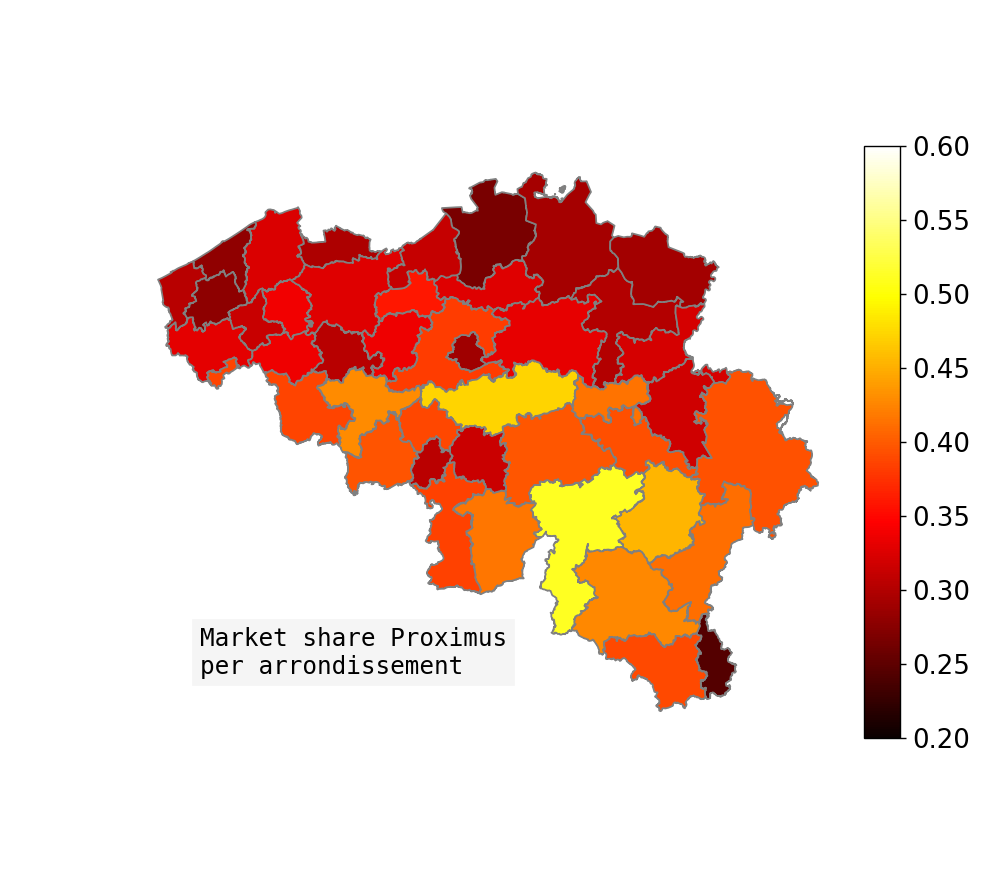

In [120]:
# Make figure
fig, ax = plt.subplots(figsize = (8,7))
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()

# Prepare empty columns
arrondissements['market_share'] = 0
# Add value to proper column
for nis in arrondissements['NISCode'].values:
    arrondissements.loc[arrondissements['NISCode']==nis,'market_share'] = value_per_pc.loc[nis, 'fraction']

vmin=0.2
vmax=0.6
fig = arrondissements.plot(column='market_share', ax=ax, cmap='hot',
                            legend=True, edgecolor = 'gray', vmin=vmin, vmax=vmax, cax=cax)

textbox = 'Market share Proximus\nper arrondissement'
plt.figtext(.20, .23, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
path = '../figures/maps/arrondissements/time_series_tests/'
chart = fig.get_figure()
# chart.savefig(f'Proximus_market-share_{d}.jpg' ,dpi=400, bbox_inches='tight')